In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

from sklearn.linear_model import LinearRegression, Lasso, Ridge, LogisticRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector, SelectFromModel
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve, f1_score, auc
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import set_config


set_config(display="diagram")
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', None)
np.set_printoptions(suppress=True )
np.set_printoptions(formatter = {"all": lambda x: str(x)})
pd.options.display.float_format = '{:.5f}'.format

In [2]:
path = "./data/kc_house_data.csv"
df_ori = pd.read_csv(path)
df = df_ori.copy()

In [3]:
df.shape

(21613, 21)

In [4]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00000,3,1.00000,1180,5650,1.00000,0,0,3,7,1180,0,1955,0,98178,47.51120,-122.25700,1340,5650
1,6414100192,20141209T000000,538000.00000,3,2.25000,2570,7242,2.00000,0,0,3,7,2170,400,1951,1991,98125,47.72100,-122.31900,1690,7639
2,5631500400,20150225T000000,180000.00000,2,1.00000,770,10000,1.00000,0,0,3,6,770,0,1933,0,98028,47.73790,-122.23300,2720,8062
3,2487200875,20141209T000000,604000.00000,4,3.00000,1960,5000,1.00000,0,0,5,7,1050,910,1965,0,98136,47.52080,-122.39300,1360,5000
4,1954400510,20150218T000000,510000.00000,3,2.00000,1680,8080,1.00000,0,0,3,8,1680,0,1987,0,98074,47.61680,-122.04500,1800,7503


In [5]:
df_lite = df.drop(columns = ["date"])

In [6]:
df_lite["price"].describe()

count     21613.00000
mean     540088.14177
std      367127.19648
min       75000.00000
25%      321950.00000
50%      450000.00000
75%      645000.00000
max     7700000.00000
Name: price, dtype: float64

### Create a category column for Classification

In [7]:
# create a category column "price category" and separate the price into 5 bins
# price category values list in the output
df_lite["price_category"] = pd.cut(df_lite["price"], bins = [0,400000,800000, 1200000, 1600000],
                                   labels = ["< 400K","400K ~ 800K","800K ~ 1.2M", "1.2M ~ 1.6M"])
df_lite["price_category"] = df_lite["price_category"].cat.add_categories(["> 1.6M"])
df_lite["price_category"].fillna("> 1.6M", inplace = True)
df_lite.value_counts("price_category")

price_category
400K ~ 800K    9829
< 400K         8839
800K ~ 1.2M    1964
1.2M ~ 1.6M     555
> 1.6M          426
dtype: int64

In [8]:
df_category = df_lite.drop(columns = ["price"])

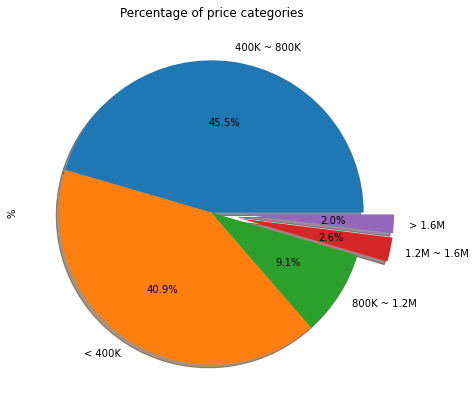

In [9]:
plt.figure(figsize = (15, 7))
df_category.value_counts("price_category").plot(kind = "pie", autopct = "%1.1f%%", shadow = True,
                                               explode = [0,0,0,0.2,0.2], radius = 1, 
                                               title = "Percentage of price categories", y = 1.2, ylabel = "%")
plt.show()

**for classification we are goint to separate the class into 2 class, housing price `greater than 800K` and housing price `less than 800K` to test our dataset and Logistic Regression Model**

In [11]:
df_category["price_binary"] = df_category["price_category"].map({"< 400K": 0, "400K ~ 800K": 0,
                                                                 "800K ~ 1.2M":1, "1.2M ~ 1.6M": 1, "> 1.6M":1})

In [12]:
df_category.value_counts("price_binary")

price_binary
0    18668
1     2945
dtype: int64

### by the previous regression model, we know the most important column is 
* sqft_living
* view
* grade
* yr_built
* lat   

We are going to use these columns for the logestic regression

In [13]:
df_clean = df_category.copy()
df_clean = df_clean[["sqft_living","view","grade","yr_built","lat","price_binary"]]

**use StandardScaler to scale the data**

In [14]:
scale = StandardScaler()
scale.fit(df_clean.drop(columns = "price_binary"))

StandardScaler()

In [15]:
X = scale.transform(df_clean.drop(columns = "price_binary"))
y = df_clean["price_binary"].to_numpy()

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [17]:
display(X_train.shape)
display(y_train.shape)
display(X_test.shape)
display(y_test.shape)

(16209, 5)

(16209,)

(5404, 5)

(5404,)

In [18]:
X_train[:5]

array([[-0.26120928099810825, -0.30575946383494007, 0.29191560999718114,
        0.748819168528556, -0.5329983425545745],
       [2.155986389294545, -0.30575946383494007, 1.993418328138786,
        1.225451725250527, -0.9811780035695817],
       [-0.10877351800667967, 3.609157178264917, 0.29191560999718114,
        -2.076930989180272, 0.517806144463015],
       [1.6877908315351573, -0.30575946383494007, 1.993418328138786,
        0.8849998990205478, -1.4271925454493324],
       [-0.021667367725863328, -0.30575946383494007, 0.29191560999718114,
        -0.6129881363913611, -0.2565847996096556]])

In [19]:
y_train[:5]

array([0, 0, 1, 0, 0])

**Run the multiclass logistic Regresiion model**

In [20]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [21]:
pred = model.predict(X_test)

**create the confusion matrics**

In [22]:
confusion = confusion_matrix(y_test, pred)

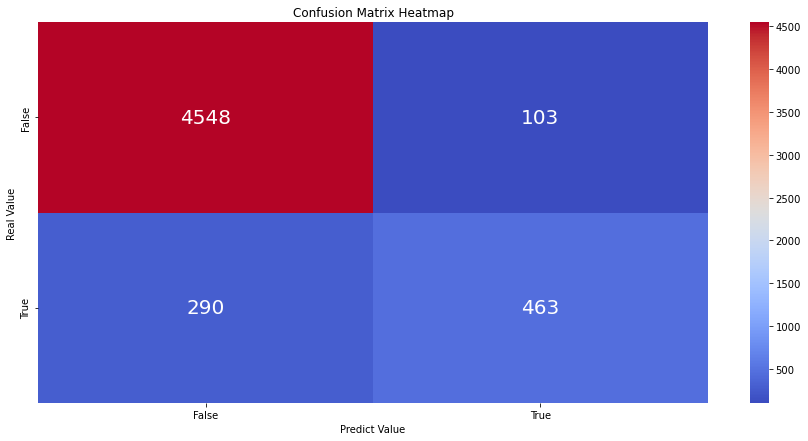

In [42]:
plt.figure(figsize = (15,7))
ax = sns.heatmap(confusion, annot = True, fmt = "d", cmap = "coolwarm", annot_kws={"size":20} )
plt.xticks([0.5,1.5], ["False","True"])
plt.yticks([0.5,1.5], ["False","True"])
plt.xlabel("Predict Value")
plt.ylabel("Real Value")
plt.title("Confusion Matrix Heatmap")
plt.show()

**print the classification report**

In [43]:
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      4651
           1       0.82      0.61      0.70       753

    accuracy                           0.93      5404
   macro avg       0.88      0.80      0.83      5404
weighted avg       0.92      0.93      0.92      5404



**From the matrix report we found that for two class `greater than 800K` and `less than 800K` houses, the predition for `less than 800K` precision is 94% at 98% recall, however for `greater than 800K` the precision is 82% at 61% recall**

**calculate the roc curve**

In [61]:
ns_probs = [0 for i in range(len(y_test))]
lr_probs = model.predict_proba(X_test)
lr_probs = lr_probs[:,1]
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

**Compare to our baseline ROC which is `50%`, our Logistic Regression model is ROC AUC is `95.1%`**

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.951


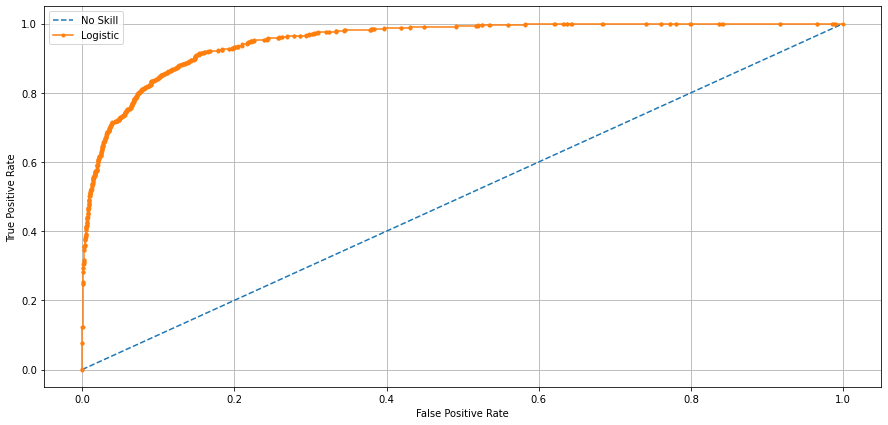

In [60]:
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
plt.figure(figsize = (15,7))
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.grid()
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

### plot the Precision Recall Curve

In [69]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_probs)
lr_f1, lr_auc = f1_score(y_test, pred), auc(lr_recall, lr_precision)

In [70]:
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Logistic: f1=0.702 auc=0.811


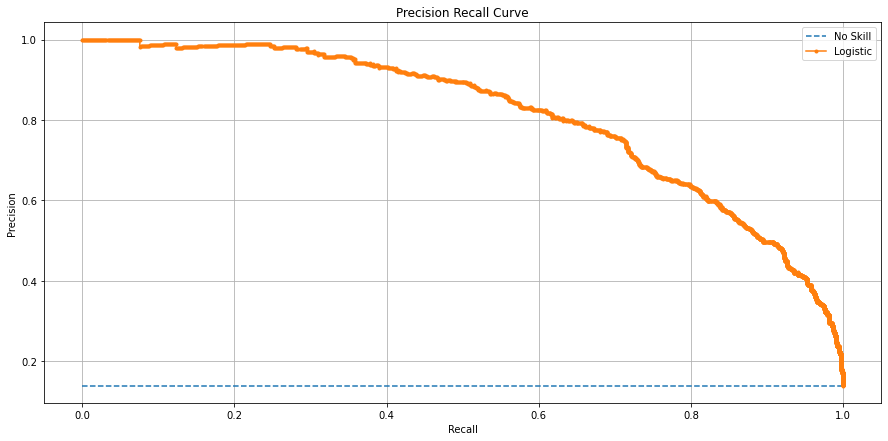

Logistic: f1=0.702 auc=0.811


In [74]:
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.figure(figsize = (15,7))
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(lr_recall, lr_precision, marker='.', label='Logistic')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.title("Precision Recall Curve")
plt.show()

print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))